<center>
    
 # **ACIT 4610 Mid - Tearm Portfolio Project 1**

 ## **Vehicle Routing Problem Using Quantum - Inspired Evolutionary Algorithms**

 ## **Group nr: 4**

</center>

## **1.Data Ingestion and Setup**

- import all necessary libraries and dependencies
- Load customer data
- Compute depot location
- define distance matrix

In [92]:
import time, ast, math, random
from typing import NamedTuple, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


Importing customers from csv file

In [81]:
df = pd.read_csv("./customers.csv")
#df.head()


Defining  the depot as the average of all customer coordinates. 

In [82]:
depot_x = df["x"].mean()
depot_y = df["y"].mean()
depot = (depot_x, depot_y)

Preparing a customer coordinates list

In [83]:
coords_df = df[["x","y"]]
customers = list(zip(coords_df["x"], coords_df["y"]))

# Defining distance matrix
def euclidean(a, b):
    return math.hypot(a[0]- b[0], a[1] - b[1])

def distance_matrix(depot, customers):
    pts = [tuple(depot)] + [tuple(c) for c in customers]
    n = len(pts)
    dmat = np.zeros((n,n), dtype = float)
    for i in range(n):
        for j in range(n):
            if i == j:
                dmat[i, j] = 0.0
            else:
                dmat[i, j] = euclidean(pts[i], pts[j])

    return dmat


## **2. Chromosome Representation and VRP Instances**


- VRP instances setup (small, medium , large)
- Individual route representation
- Permutation and cut points encoding

In [84]:
class VRPInstance: 
    def __init__(self, depot, vehicles, customers):
        self.depot = depot
        self.customers = customers
        self.vehicles = vehicles

# Small Group 

Instance1_smallgroup = VRPInstance(depot=depot, vehicles=3, customers=customers[:10])
Instance2_smallgroup = VRPInstance(depot=depot, vehicles=8, customers=customers[:18])

# Medium Group

Instance3_mediumgroup = VRPInstance(depot=depot, vehicles=11, customers=customers[:17])
Instance4_mediumgroup = VRPInstance(depot=depot, vehicles=22, customers=customers[:28])

# Large Group
Instance5_largegroup = VRPInstance(depot=depot, vehicles=20, customers=customers[:50])
Instance6_largegroup = VRPInstance(depot=depot, vehicles=48, customers=customers[:48])


# Representation in order to choose the a chromosome format for the VRP.


class Individual(NamedTuple):
    perm: List[int]  # visit order
    cuts: List[int]  # split it to routes for each vehicle  

# random intializer

def random_individual(N: int, V: int, rng:random.Random) -> Individual:
    # random permutation of all customers
    if V > N:
        raise ValueError("the number of vehicles cannot exceed number of customers.")
    
    perm = list(range(1, N+1))
    rng.shuffle(perm)

    #choose exactly V-1 unique cut positions
    # here maybe an error handler later

    cuts = sorted(rng.sample(range(1, N), V-1))  # random cuts same number as number of vehicles

    return Individual(perm=perm, cuts=cuts)

# decode into actualy routes

def decode_routes(ind: Individual, V:int) -> List[List[int]]:
    perm = ind.perm
    cuts = ind.cuts

    routes = []
    prev = 0
    for c in cuts:
        routes.append(perm[prev:c])
        prev = c
    routes.append(perm[prev:])

    return routes

def route_distance(route: List[int], dmat) -> float: # distance per vehicle
    total = 0.0
    prev = 0
    for c in route:
        total += dmat[prev, c]
        prev = c
    total += dmat[prev, 0] # final route to back to depot
    return float(total)

def total_distance(ind: Individual, dmat, V: int) -> float:# distance of all the routes in a scenario
    routes = decode_routes(ind, V)
    return sum(route_distance(r, dmat) for r in routes)

## **3. Genetic Algorithm Design**
### **3.1 GA Operators**
- selection
- crossover
- mutation


In [87]:
def fitness(ind: Individual, dmat, V: int) -> float:
    # inorder to maximize fitness we return the negative of the total distance
    return -total_distance(ind, dmat, V)

def tournament_selection_idx(fitnesses: List[float], k: int, rng: random.Random) -> int:
    # return index of selected parent via k-tournament where higher fitness wins
    cand = [rng.randrange(len(fitnesses)) for i in range(k)]
    return max(cand, key=lambda i: fitnesses[i])

def order_crossover(p1: List[int], p2: List[int], rng: random.Random) -> Tuple[List[int], List[int]]:
    # permutation order crossover between two parents
    n = len(p1)
    a, b = sorted([rng.randrange(n), rng.randrange(n)])
    def ox(a, b, x, y):
        child = [None]*n
        child[a:b+1] = x[a:b+1]
        fill = [g for g in y if g not in child]
        pos = 0
        for i in range(n):
            if child[i] is None:
                child[i] = fill[pos]; pos +=1
        return child
    return ox(a,b,p1,p2), ox(a,b,p2,p1)

def repair_cuts(cuts: List[int], N: int, V:int, rng: random.Random) -> List[int]:
    clamped = [min(max(1, c), N-1) for c in cuts] #clamp cuts to valid range
    uniq = sorted(set(clamped))
    need = (V-1)- len(uniq)
    if need > 0:
        #fill missing positions
        pool = [c for c in range(1,N) if c not in uniq]
        add = rng.sample(pool, need)
        uniq = sorted(uniq + add)
    elif need < 0:
        # trim number of cuts if to many
        drop = rng.sample(range(len(uniq)), -need)
        keep = [i for i in range(len(uniq)) if i not in drop]
        uniq = [uniq[i] for i in keep]
    return uniq

def cuts_crossover(c1: List[int], c2: List[int], N: int, V: int, rng: random.Random) -> Tuple[List[int], List[int]]:
    # one point crossover between sorted cuts and then repair
    if not c1 and not c2:
        return [], []
    a = rng.randrange(0, max(len(c1), 1))
    ch1 = sorted(c1[:a] + c2[a:])
    ch2 = sorted(c2[:a] + c1[a:])
    ch1 = repair_cuts(ch1, N, V, rng)
    ch2 = repair_cuts(ch2, N, V, rng)
    return ch1, ch2

def swap_mutation_perm(p: List[int], p_mut:float, rng: random.Random) -> List[int]:
    #swap mutation for permutation
    q = p[:]
    if rng.random() < p_mut and len(q) >= 2:
        i , j = rng.sample(range(len(q)), 2)
        q[i], q[j] = q[j], q[i]
    return q

def jitter_mutation_cuts(cuts: List[int], N:int, V:int, p_mut: float, rng: random.Random) -> List[int]:
    # jitter mutation for cuts positions
    q = cuts[:]
    if rng.random() < p_mut and q:
        i = rng.randrange(len(q))
        shift = rng.choice([1,-1])
        q[i] = min(max(1, q[i] + shift), N-1)
    return repair_cuts(q, N, V, rng)

### **3.2 GA Engine**

Main GA function to:

- initialize population
- loop over generations
- apply GA operations
- return best solution and history

In [88]:
def genetic_algorithm(dmat, N, V, pop_size, generations, k_tourn, pc, pm_perm, pm_cuts, seed, log_convergence):
    rng = random.Random(seed)

    # init population
    pop = [random_individual(N, V, rng) for _ in range(pop_size)]
    fits = [fitness(ind, dmat, V) for ind in pop]

    best_hist = []  # best in each generation in order to track if the algorithm works

    # evolve
    for _ in range(generations):
        new_pop = []
        while len(new_pop) < pop_size:
            # select parents
            a = tournament_selection_idx(fits, k=k_tourn, rng=rng)
            b = tournament_selection_idx(fits, k=k_tourn, rng=rng)
            p1, p2 = pop[a], pop[b]

            # crossover
            if rng.random() < pc:
                ch1_perm, ch2_perm = order_crossover(p1.perm, p2.perm, rng)
                ch1_cuts, ch2_cuts = cuts_crossover(p1.cuts, p2.cuts, N, V, rng)
            else:
                ch1_perm, ch2_perm = p1.perm[:], p2.perm[:]
                ch1_cuts, ch2_cuts = p1.cuts[:], p2.cuts[:]

            # mutation
            ch1_perm = swap_mutation_perm(ch1_perm, pm_perm, rng)
            ch2_perm = swap_mutation_perm(ch2_perm, pm_perm, rng)
            ch1_cuts = jitter_mutation_cuts(ch1_cuts, N, V, pm_cuts, rng)
            ch2_cuts = jitter_mutation_cuts(ch2_cuts, N, V, pm_cuts, rng)

            # children
            c1 = Individual(perm=ch1_perm, cuts=ch1_cuts)
            c2 = Individual(perm=ch2_perm, cuts=ch2_cuts)
            new_pop.extend([c1, c2])

        # replacement
        pop = new_pop[:pop_size]
        fits = [fitness(ind, dmat, V) for ind in pop]

        if log_convergence:
            best_idx = max(range(pop_size), key=lambda i: fits[i])
            best_hist.append(-fits[best_idx])  # store positive distance

    # best at the end
    best_idx = max(range(pop_size), key=lambda i: fits[i])
    best = pop[best_idx]
    best_dist = -fits[best_idx]

    return best, best_dist, best_hist

## **4.Visualization**
- Visualize routes for each instance



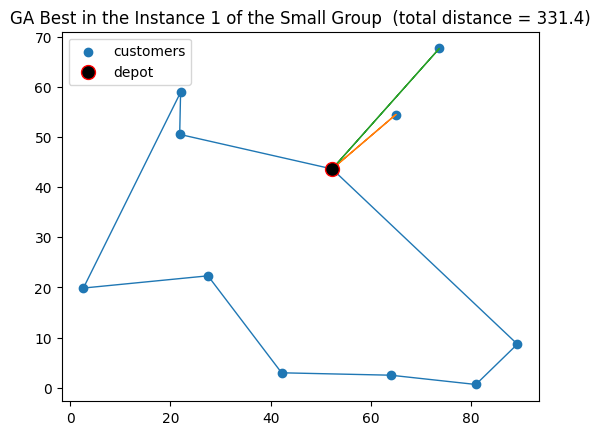

In [89]:
def plot_routes(ind, customers, depot, n_vehicles, number_points=False, title=None):

    routes = decode_routes(ind, n_vehicles)

    # scatter: customers + depot
    xs = [xy[0] for xy in customers]
    ys = [xy[1] for xy in customers]
    plt.figure()
    plt.scatter(xs, ys, label="customers")
    plt.scatter([depot[0]], [depot[1]], marker=".", s=400, label="depot", edgecolors= "red", color ="black", zorder=10)

    # draw each route
    for r in routes:
        if not r:
            continue
        # build path: depot (0) -> r -> depot (0)
        xs_path = [depot[0]] + [customers[i-1][0] for i in r] + [depot[0]]
        ys_path = [depot[1]] + [customers[i-1][1] for i in r] + [depot[1]]
        plt.plot(xs_path, ys_path, linewidth=1.0)

    plt.gca().set_aspect("equal", adjustable="box")
    plt.legend()
    plt.title(title or f"Decoded Routes (vehicles={n_vehicles})")
    plt.show()

# Choosing the instance
instance = Instance1_smallgroup

dmat = distance_matrix(instance.depot, instance.customers)

# Running the GA
best_ind, best_dist, best_hist = genetic_algorithm(dmat, N=len(instance.customers), V=instance.vehicles, pop_size=120, generations=20, k_tourn=3, pc=0.9, pm_perm=0.2, pm_cuts=0.2, seed=42, log_convergence=True)


# Ploting the routes
plot_routes(best_ind, customers=instance.customers, depot=instance.depot, n_vehicles=instance.vehicles, number_points=False,
            title=f"GA Best in the Instance 1 of the Small Group  (total distance = {best_dist:.1f})")

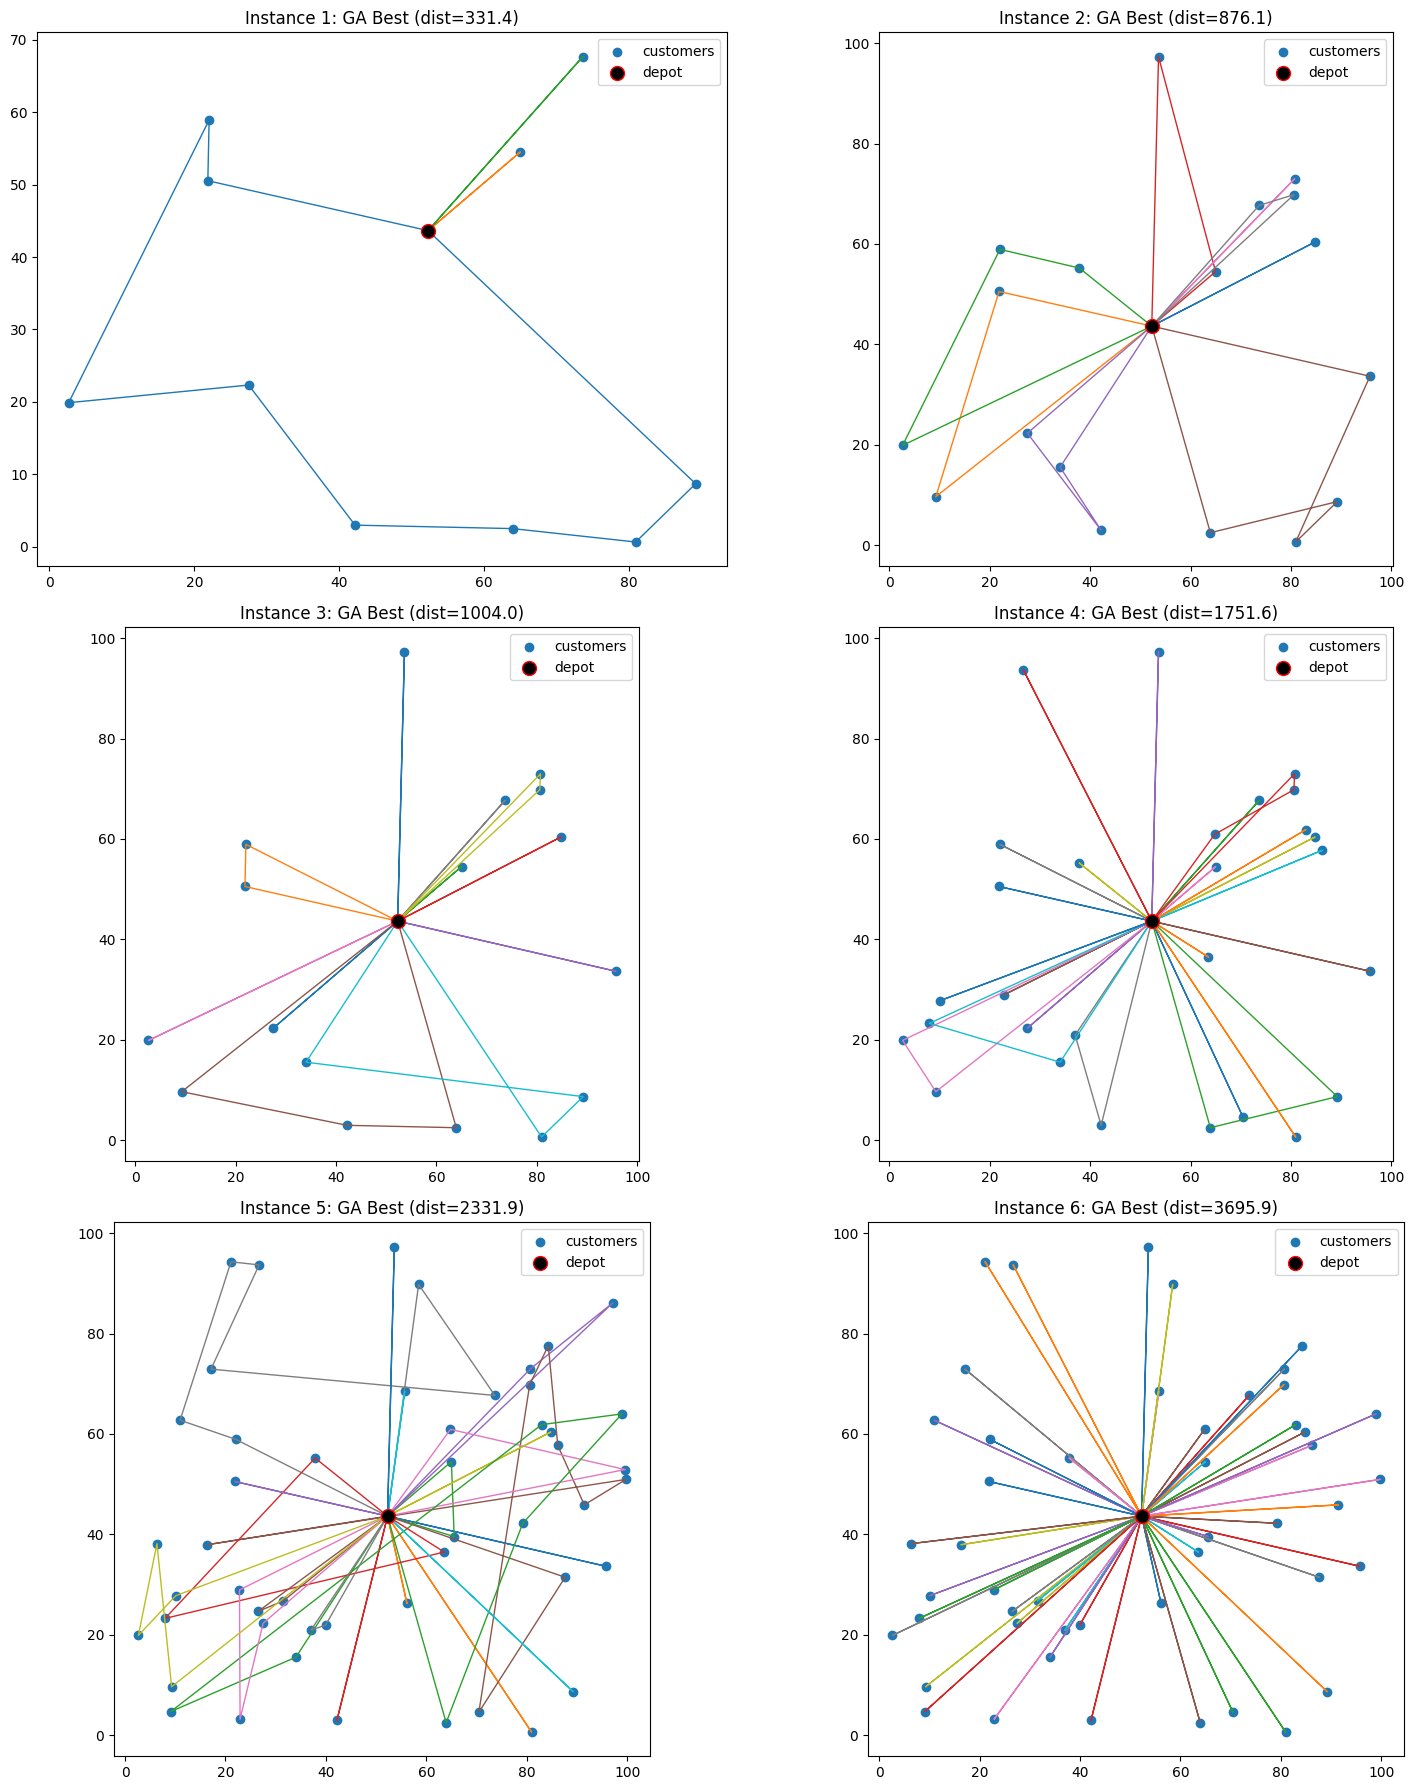

In [90]:
# List of instances
instances = [Instance1_smallgroup, Instance2_smallgroup, Instance3_mediumgroup,
             Instance4_mediumgroup, Instance5_largegroup, Instance6_largegroup]

n_instances = len(instances)
cols = 2
rows = (n_instances + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(8*cols, 6*rows))
axes = axes.flatten()

for idx, instance in enumerate(instances):
    dmat = distance_matrix(instance.depot, instance.customers)

    # Running GA
    best_ind, best_dist, best_hist = genetic_algorithm(dmat, N=len(instance.customers), V=instance.vehicles, pop_size=120, generations=20, k_tourn=3, pc=0.9, pm_perm=0.2, pm_cuts=0.2,  seed=42, log_convergence=True)

    # Decode routes
    routes = decode_routes(best_ind, instance.vehicles)

    # Plot on subplot
    ax = axes[idx]
    xs = [xy[0] for xy in instance.customers]
    ys = [xy[1] for xy in instance.customers]
    ax.scatter(xs, ys, label="customers")
    ax.scatter([instance.depot[0]], [instance.depot[1]], marker=".", s=400, label="depot",
               edgecolors="red", color="black", zorder=10)

    for r in routes:
        if not r:
            continue
        xs_path = [instance.depot[0]] + [instance.customers[i-1][0] for i in r] + [instance.depot[0]]
        ys_path = [instance.depot[1]] + [instance.customers[i-1][1] for i in r] + [instance.depot[1]]
        ax.plot(xs_path, ys_path, linewidth=1.0)

    ax.set_aspect("equal", adjustable="box")
    ax.legend()
    ax.set_title(f"Instance {idx+1}: GA Best (dist={best_dist:.1f})")

# Hiding all the empty subplots
for j in range(idx+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## **5. Performance Evaluation**

- Compare metrics such as total distance, GA runtime and convergence behavior of small, medium and large

- Test 3 sets of GA parameters and run all the 6 instances with all the 3 parameters sets, record metrics and compare the results

In [91]:
param_sets = {
    "Balanced": {
        "pop_size": 50, "generations": 200, "k_tourn": 3,
        "pc": 0.7, "pm_perm": 0.01, "pm_cuts": 0.1
    },
    "High exploration": {
        "pop_size": 150, "generations": 500, "k_tourn": 3,
        "pc": 0.85, "pm_perm": 0.05, "pm_cuts": 0.2
    },
    "Focus exploitation": {
        "pop_size": 20, "generations": 100, "k_tourn": 3,
        "pc": 0.6, "pm_perm": 0.005, "pm_cuts": 0.5
    }
}

n_runs = 20  # 20 independent seeds

instance_labels = {
    1: "Small-1",
    2: "Small-2",
    3: "Medium-3",
    4: "Medium-4",
    5: "Large-5",
    6: "Large-6"
}

results = []

for inst_id, instance in enumerate(instances, start=1):
    dmat = distance_matrix(instance.depot, instance.customers)

    for set_name, params in param_sets.items():
        dists = []
        times = []
        histories = []

        for run in range(n_runs):
            start = time.time()
            best_ind, best_dist, best_hist = genetic_algorithm(
                dmat,
                N=len(instance.customers),
                V=instance.vehicles,
                seed=run,
                log_convergence=True,
                **params
            )
            runtime = time.time() - start

            dists.append(best_dist)
            times.append(runtime)
            histories.append(best_hist)

        results.append({
            "Instance": inst_id,
            "Group": instance_labels[inst_id],
            "ParamSet": set_name,
            "BestDist": float(np.min(dists)),
            "MeanDist": float(np.mean(dists)),
            "WorstDist": float(np.max(dists)),
            "StdDist": float(np.std(dists)),
            "BestRuntime": float(np.min(times)),
            "MeanRuntime": float(np.mean(times)),
            "WorstRuntime": float(np.max(times)),
            "RuntimeStd": float(np.std(times)),
            "Histories": histories
        })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Optional: reorder columns nicely
cols = [
    "Instance", "Group", "ParamSet",
    "BestDist", "MeanDist", "WorstDist", "StdDist",
    "BestRuntime", "MeanRuntime", "WorstRuntime", "RuntimeStd",
    "Histories"
]
df_results = df_results[cols]

# Save to CSV
df_results.to_csv("results.csv", index=False)

# Optional preview
# print(df_results.head())


### **5.1 Mean Runtime**

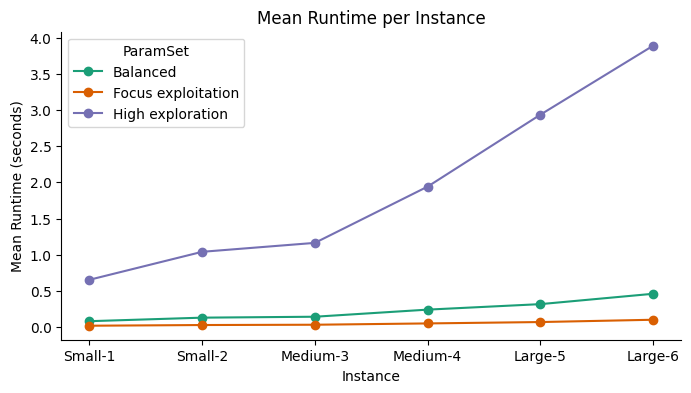

In [23]:
# Helper function to plot any metric per instance
def plot_instance_metric(series, series_name, series_index=0, ycol="MeanDist"):
    palette = list(sns.palettes.mpl_palette('Dark2'))
    xs = series['Instance']
    ys = series[ycol]
    
    plt.plot(xs, ys, marker='o', label=series_name,
             color=palette[series_index % len(palette)])

# Plot Mean Runtime for each parameter set
plt.figure(figsize=(8, 4))
df_results_sorted = df_results.sort_values('Instance')

for i, (name, group) in enumerate(df_results_sorted.groupby("ParamSet")):
    plot_instance_metric(group, series_name=name, series_index=i, ycol="MeanRuntime")

plt.title("Mean Runtime per Instance")
plt.xlabel("Instance")
plt.ylabel("Mean Runtime (seconds)")

plt.xticks(
    ticks=df_results_sorted["Instance"].unique(),
    labels=[instance_labels[i] for i in df_results_sorted["Instance"].unique()]
)

plt.legend(title="ParamSet")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()


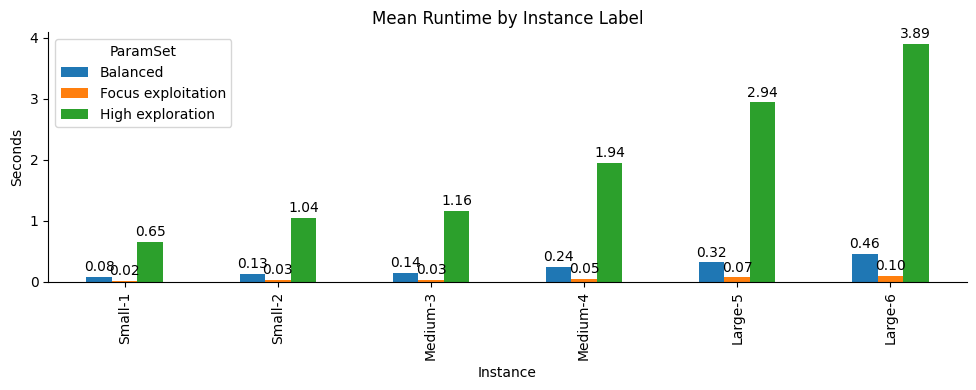

In [35]:
#barchart
pivot = df_results.pivot(index="Group", columns="ParamSet", values="MeanRuntime")

# Define the desired order
group_order = ["Small-1", "Small-2", "Medium-3", "Medium-4", "Large-5", "Large-6"]
pivot = pivot.reindex(group_order)

# Plot
ax = pivot.plot(kind="bar", figsize=(10, 4))
ax.set_title("Mean Runtime by Instance Label")
ax.set_xlabel("Instance")
ax.set_ylabel("Seconds")
ax.spines[['top', 'right']].set_visible(False)
plt.legend(title="ParamSet")

# Show values on bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=2)

plt.tight_layout()
plt.show()

### **5.2 Mean Distance**

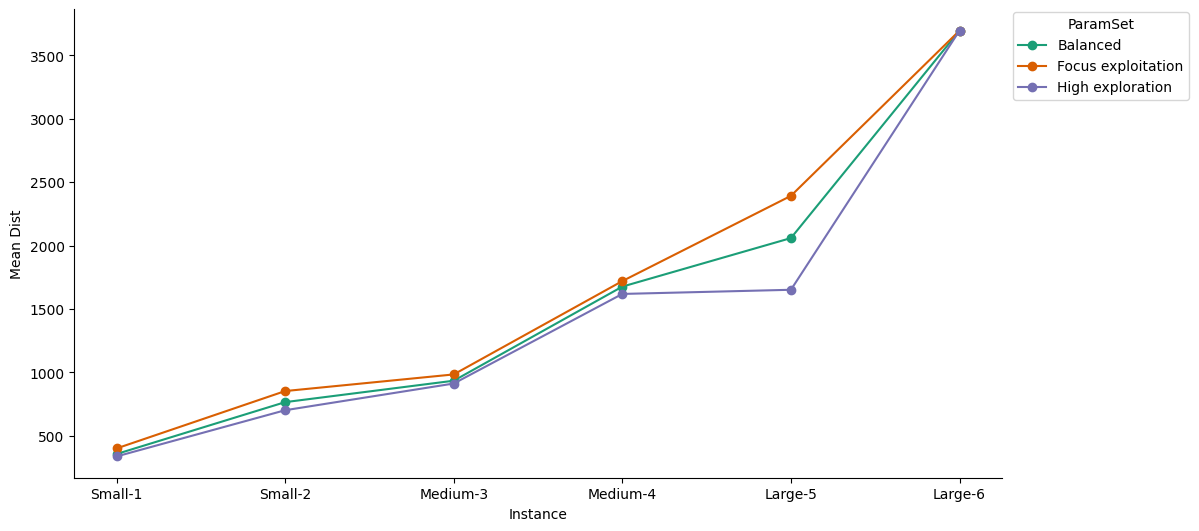

In [24]:

# Mean Distance plot
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_results.sort_values('Instance', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ParamSet')):
    plot_instance_metric(series, series_name, i, ycol="MeanDist")
fig.legend(title='ParamSet', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Instance')
plt.ylabel('Mean Dist')
plt.xticks(ticks=df_sorted['Instance'].unique(),
           labels=[instance_labels[i] for i in df_sorted['Instance'].unique()])
plt.show()


distance increases with instance size. Differences between parameter sets are small, but larger populations or more generations tend to provide slightly better results on the medium and large instances.

### 5.3 **Best distance**

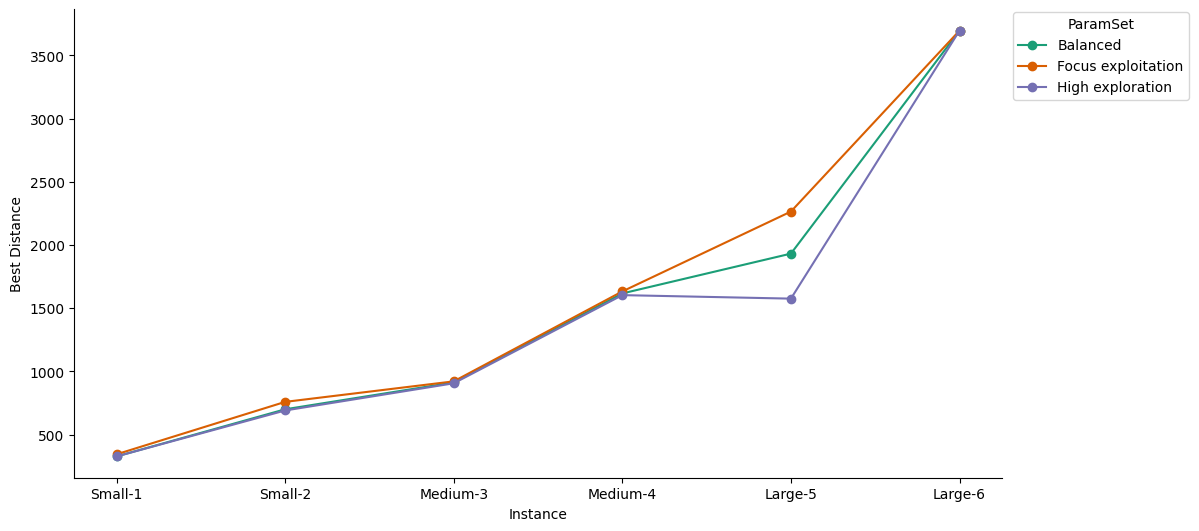

In [26]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_results.sort_values('Instance', ascending=True)

for i, (series_name, series) in enumerate(df_sorted.groupby('ParamSet')):
    plot_instance_metric(series, series_name, i, ycol="BestDist")

fig.legend(title='ParamSet', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Instance')
plt.ylabel('Best Distance')
plt.xticks(
    ticks=df_sorted['Instance'].unique(),
    labels=[instance_labels[i] for i in df_sorted['Instance'].unique()]
)
plt.show()


### **5.4 convergence curves**

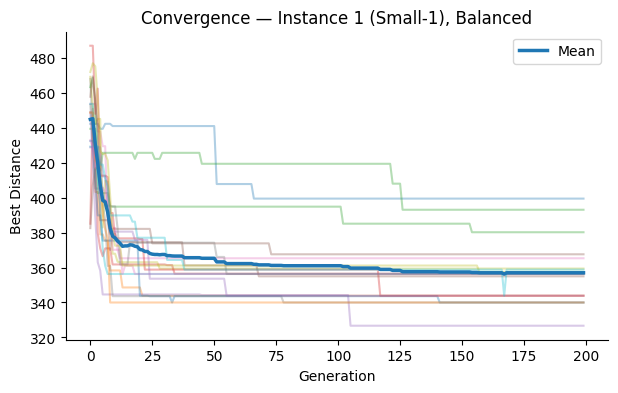

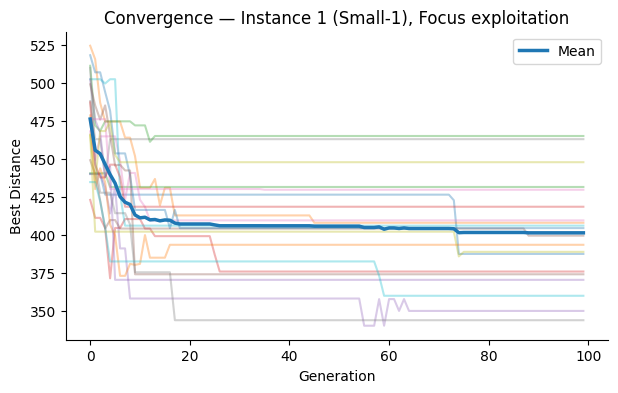

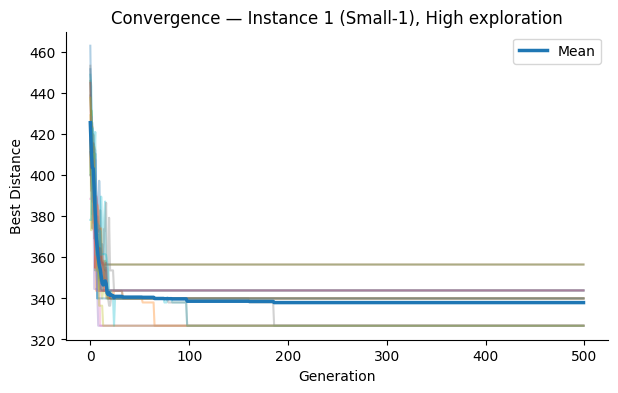

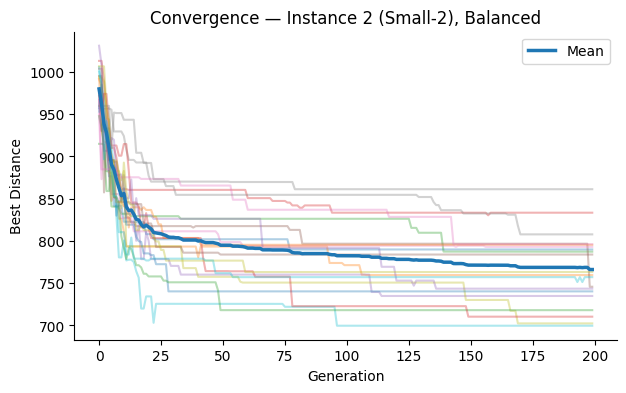

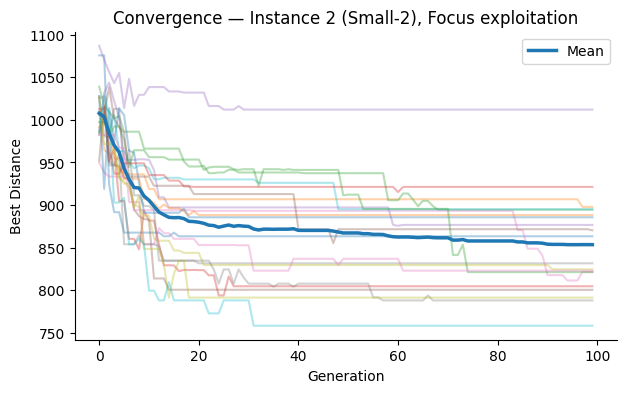

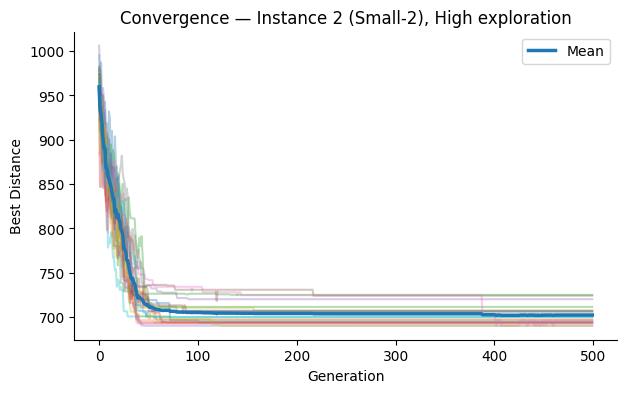

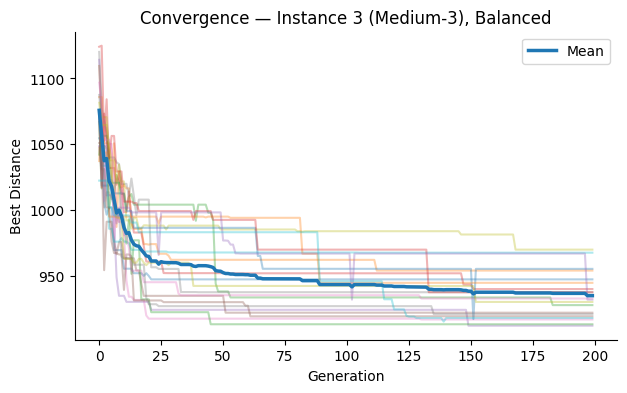

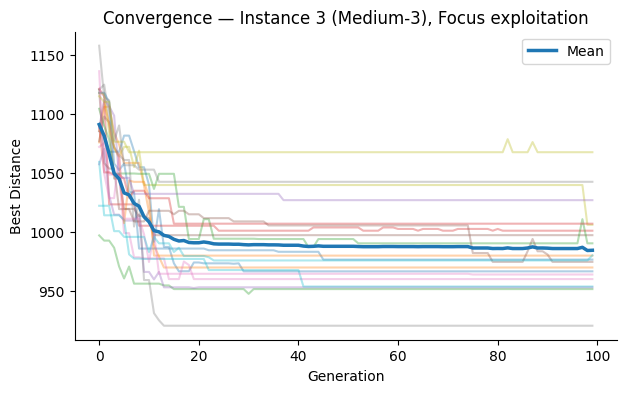

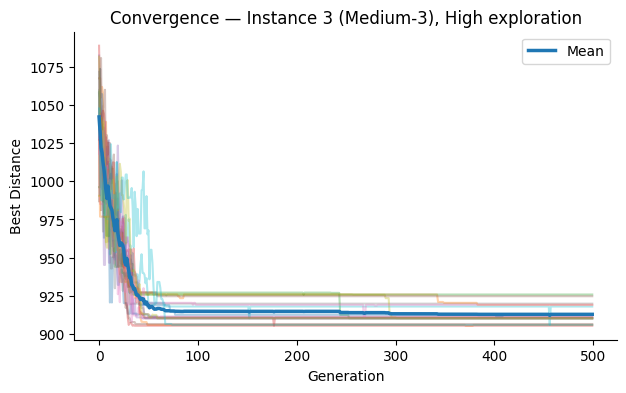

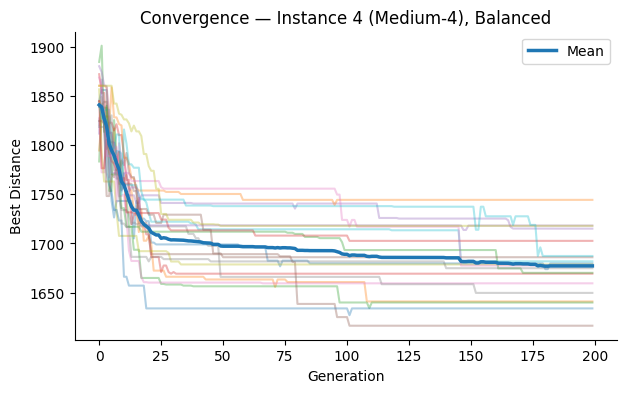

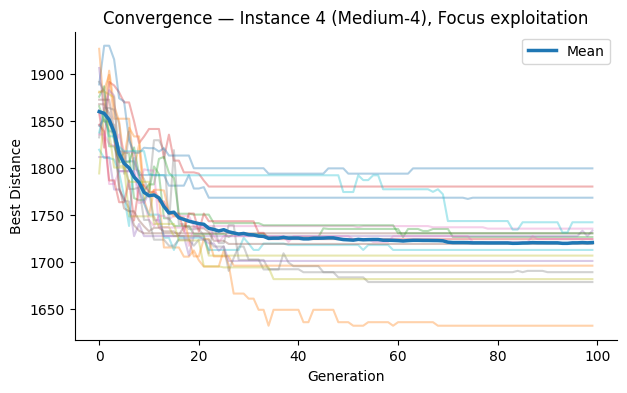

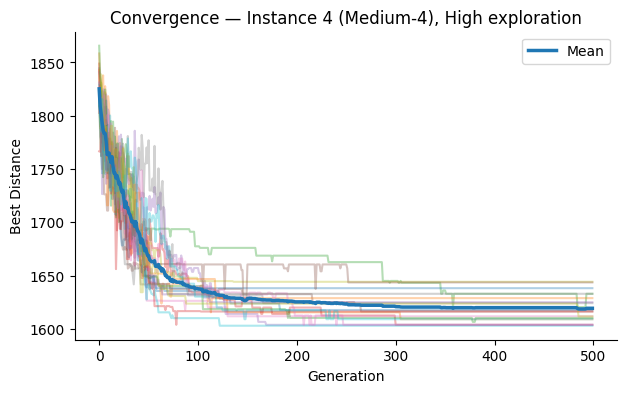

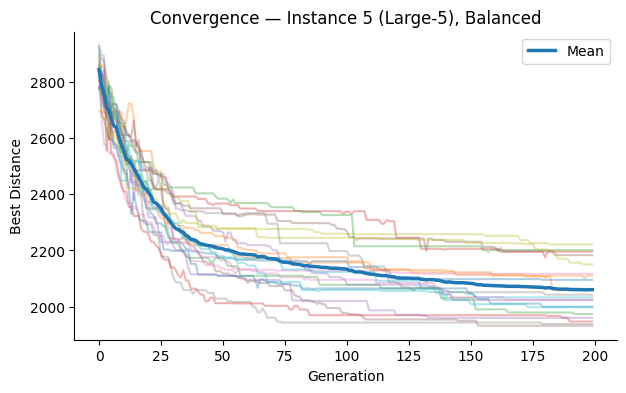

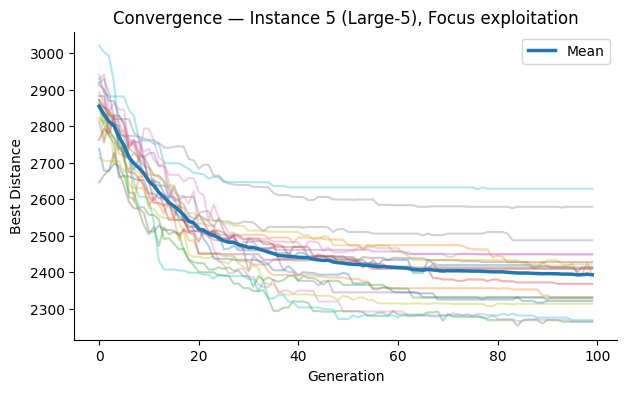

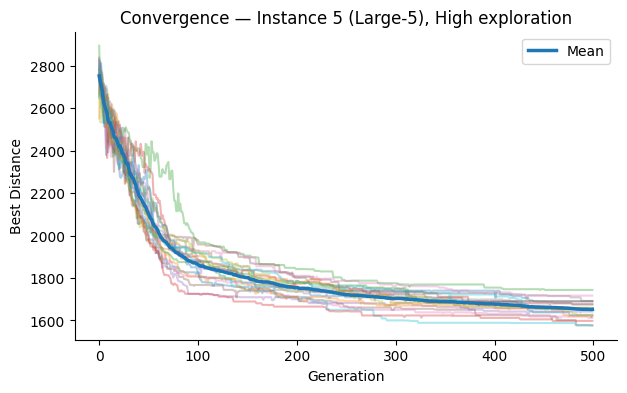

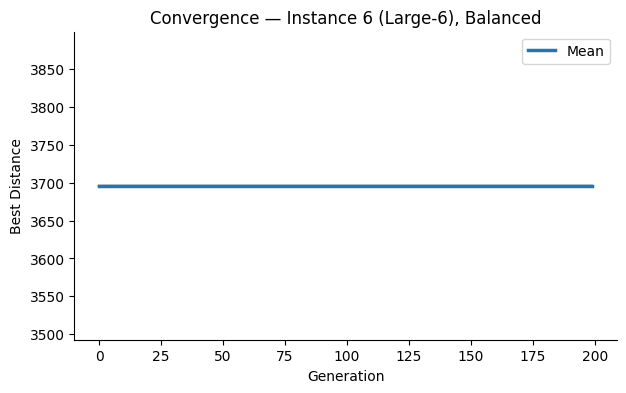

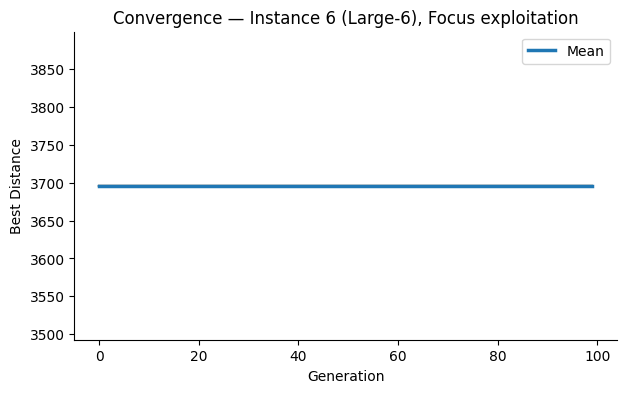

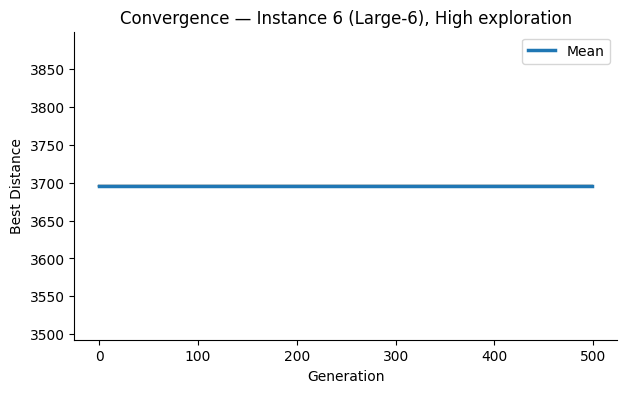

In [29]:
# Helper: ensure Histories is a list-of-lists (after CSV it may be a string)
def parse_histories(H):
    if isinstance(H, str):
        return ast.literal_eval(H)
    return H
# One figure per (Instance, ParamSet): faint lines = each run; bold = mean curve
dfh = df_results.copy()
dfh["Histories"] = dfh["Histories"].apply(parse_histories)

for (inst, pset), row in dfh.groupby(["Instance","ParamSet"]):
    runs = row.iloc[0]["Histories"]  # list of lists (one per run)
    # Plot each run
    plt.figure(figsize=(7,4))
    for r in runs:
        plt.plot(r, alpha=0.35)
    # Mean curve across runs (same length within a param set)
    maxlen = max(len(r) for r in runs)
    arr = np.vstack([np.array(r + [r[-1]]*(maxlen-len(r))) for r in runs])  # pad just in case
    mean_curve = arr.mean(axis=0)
    plt.plot(mean_curve, linewidth=2.5, label="Mean", zorder=10)
    plt.title(f"Convergence — Instance {inst} ({dfh.loc[dfh['Instance']==inst,'Group'].iloc[0]}), {pset}")
    plt.xlabel("Generation")
    plt.ylabel("Best Distance")
    plt.legend()
    plt.gca().spines[['top','right']].set_visible(False)
    plt.show()


### **6.Summary**
- tables that sumarize the result

In [ ]:
dfh["Histories"] = dfh["Histories"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
ps_map = {
    "Balanced": "A",
    "High exploration": "B",
    "Focus exploitation": "C"
}
dfh["ParamCode"] = dfh["ParamSet"].map(ps_map)

### **6.1 Solution quality table**

In [ ]:
q = dfh.copy()
q = q.rename(columns={
    "BestDist": "Best",
    "MeanDist": "Avg",
    "WorstDist": "Worst"
})

tbl_quality = (
    q.pivot(index="Instance", columns="ParamCode", values=["Best", "Avg", "Worst"])
     .swaplevel(0,1,axis=1).sort_index(axis=1, level=0)
     .reindex(columns=["A", "B", "C"], level=0)
     .round(3).astype(int)  # whole numbers
)

#tbl_quality.to_csv("table_solution_quality.csv")
display(tbl_quality.style.set_caption("Solution Quality"))


### **6.2 Computational efficiency table**

In [ ]:
e = dfh.rename(columns={
    "BestRuntime": "Best",
    "MeanRuntime": "Avg",
    "WorstRuntime": "Worst"
})[["Instance", "ParamCode", "Best", "Avg", "Worst"]]

tbl_eff = (
    e.pivot(index="Instance", columns="ParamCode", values=["Best", "Avg", "Worst"])
     .swaplevel(0,1,axis=1).sort_index(axis=1, level=0)
     .reindex(columns=["A", "B", "C"], level=0)
     .round(4)
)

#tbl_eff.to_csv("table_computational_efficiency.csv")
display(tbl_eff.style.set_caption("Computational Efficiency"))


### **6.3 Convergence table**

In [ ]:
EPS = 0.05

def gens_to_within_eps(hist, eps=EPS):
    final = hist[-1]
    thresh = final * (1 + eps)
    for g, v in enumerate(hist):
        if v <= thresh:
            return g
    return len(hist) - 1

rows = []
for _, r in dfh.iterrows():
    gens = [gens_to_within_eps(h) for h in r["Histories"]]
    rows.append({
        "Instance": r["Instance"],
        "ParamCode": r["ParamCode"],
        "Best": min(gens),
        "Avg": round(sum(gens)/len(gens), 0),
        "Worst": max(gens)
    })

c = pd.DataFrame(rows)

tbl_convergence = (
    c.pivot(index="Instance", columns="ParamCode", values=["Best", "Avg", "Worst"])
     .swaplevel(0,1,axis=1).sort_index(axis=1, level=0)
     .reindex(columns=["A", "B", "C"], level=0)
     .round(0).astype(int)
)

#tbl_convergence.to_csv("table_convergence_rate.csv")
display(tbl_convergence.style.set_caption("Convergence Rate"))
